# Test curve fitting

The function `y = sinc(10 * x)` is fitted using a Shallow Neural Network with 61 parameters.
Despite the triviality of the problem, first-order methods such as Adam fail to converge, while Levenberg–Marquardt converges rapidly with very low loss values. The values of learning_rate were chosen experimentally on the basis of the results obtained by each algorithm.

In [1]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

FileNotFoundError: [Errno 2] No such file or directory: './content'

In [11]:
!pip install tensorflow --ignore-installed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.3 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 1.3 MB/s eta 0:00:00ta 0:00:01
  Using cached setuptools-69.0.3-py3-none-any.whl.metadata (6.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.1 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 3.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 3.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 46.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 43.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.1 MB/

# Setup Levenberg-Marquardt
### Install dependencies from GitHub

In [12]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.preprocessing import MaxAbsScaler

def peaks(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return x, y, z

def create_dataframe(grid):
   x, y, z = peaks(grid)
   data = {'X': x.flatten(), 'Y': y.flatten(), 'Z': z.flatten()}
   df = pd.DataFrame(data)
   return df

In [4]:
df_25 = create_dataframe(grid=5)
df_1000 = create_dataframe(grid=32)

In [5]:
df_25

,X,Y,Z
0,-2.0,-2.0,0.046835
1,-1.0,-2.0,-0.592128
2,0.0,-2.0,-4.759612
3,1.0,-2.0,-2.102351
4,2.0,-2.0,-0.061640
5,-2.0,-1.0,-0.130053
6,-1.0,-1.0,1.855892
7,0.0,-1.0,-0.723906
8,1.0,-1.0,-0.272917
9,2.0,-1.0,0.499636


In [6]:
df_1000

,X,Y,Z
0,-2.000000,-2.0,0.046835
1,-1.870968,-2.0,0.060663
2,-1.741935,-2.0,0.070183
3,-1.612903,-2.0,0.067332
4,-1.483871,-2.0,0.039844
...,...,...,...
1019,1.483871,2.0,0.708371
1020,1.612903,2.0,0.487302
1021,1.741935,2.0,0.325461
1022,1.870968,2.0,0.211038


In [8]:
def split_df(df):
    df = df.sample(frac=1).reset_index(drop=True)  # Randomiza as linhas

    _input = np.vstack([df['X'], df['Y']]).T
    _output = np.array(df['Z'])
    return (_input, _output)

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import levenberg_marquardt as lm
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error
from keras import regularizers
from keras import initializers

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      train_dataset = tf.data.Dataset.from_tensor_slices((input, output))
      train_dataset = train_dataset.shuffle(len(input))
      train_dataset = train_dataset.batch(self.batch_size).cache()
      train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (train_dataset, input, output)


    def split_dataset(self, input, output, sup_input, sup_output):

      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, random_state=42)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, random_state=42)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(sup_input, sup_output)
      self.dataset, self.input, self.output = self.create_dataset(input, output)


    def create_model(self, input_size=2, sumary=False):
      regularizer = regularizers.L2(0.2)
      initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=42)

      self.model = tf.keras.Sequential([
          tf.keras.layers.Dense(30,
                                activation='tanh',
                                input_shape=(input_size,),
                                kernel_regularizer=regularizer,
                                kernel_initializer=initializer,
                                ),
          tf.keras.layers.Dense(16,
                                activation='tanh',
                                kernel_regularizer=regularizer,
                                kernel_initializer=initializer,
                                ),
          tf.keras.layers.Dense(1,
                                activation='linear',
                                kernel_regularizer=regularizer,
                                kernel_initializer=initializer,
)])

      if (sumary == True):
        self.model.summary()

      self.model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
          loss=tf.keras.losses.MeanSquaredError())

      self.lm_model = lm.ModelWrapper(
          tf.keras.models.clone_model(self.model))

      self.lm_model.compile(
          optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
          loss=lm.MeanSquaredError())

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
          self.sup_prediction = self.lm_model.predict(self.sup_input)
          self.test_prediction = self.lm_model.predict(self.test_input)

          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.test_prediction.flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()
          sup_pred = self.sup_prediction.flatten()

          r2 = r2_score(self.output, pred)
          r2_test = r2_score(self.test_output, test_pred)
          r2_val = r2_score(self.val_output, val_pred)
          r2_vt = r2_score(self.vt_output, vt_pred)
          r2_sup = r2_score(self.sup_output, sup_pred)

          mse = mean_squared_error(self.output, pred)
          mse_test = mean_squared_error(self.test_output, test_pred)
          mse_val = mean_squared_error(self.val_output, val_pred)
          mse_vt = mean_squared_error(self.vt_output, vt_pred)
          mse_sup = mean_squared_error(self.sup_output, sup_pred)

          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt
                          }

          return metrics


    def plot_results(self):


      fig = plt.figure(figsize=(18, 6))
      ax0 = fig.add_subplot(1, 3, 1, projection='3d')
      ax2 = fig.add_subplot(1, 3, 2, projection='3d')
      ax1 = fig.add_subplot(1, 3, 3)

      ax0.set_title('Superficie Fit')
      ax0.scatter(self.sup_input[:, 0], self.sup_input[:, 1], self.sup_prediction, c='r', marker='s', label="lm")
      ax0.scatter(self.sup_input[:, 0], self.sup_input[:, 1], self.sup_output, c='b', marker='o', label="reference")
      ax0.legend()

      ax2.set_title('Teste Fit')
      ax2.scatter(self.test_input[:, 0], self.test_input[:, 1], self.test_prediction, c='r', marker='s', label="lm")
      ax2.scatter(self.test_input[:, 0], self.test_input[:, 1], self.test_output, c='b', marker='o', label="reference")
      ax2.legend()

      ax1.plot(self.results.history['loss'], label='Erro Treino')
      ax1.plot(self.results.history['val_loss'], label='Erro validação')
      ax1.set_title('Histórico de Treinamento')
      ax1.set_ylabel('Função de Custo')
      ax1.set_xlabel('Épocas de Treinamento')
      ax1.legend(['Erro Treino', 'Erro validação'])

      plt.show()

2024-01-22 19:38:39.449791: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-22 19:38:39.504880: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 19:38:39.504919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 19:38:39.507478: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 19:38:39.517019: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-22 19:38:39.517917: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [14]:
def Test(full=False):
  trainer = TrainWithSmallDataset()
  input_25, output_25 = split_df(df_25)
  input_1000, output_1000 = split_df(df_1000)
  trainer.split_dataset(input_25, output_25, input_1000, output_1000)
  if (full == True):
    trainer.split_dataset(input_1000, output_1000, input_1000, output_1000)
  trainer.create_model()
  trainer.train_using_lm(trainer.train_dataset, epochs=500)
  metrics = trainer.get_metrics()
  trainer.plot_results()
  print(metrics)
  return(metrics)

# Treinando com 25 dados

## 100


Elapsed time:  1.0049725939998098
Stopped at epoch:  11
1/1 [==============================] - 0s 15ms/step


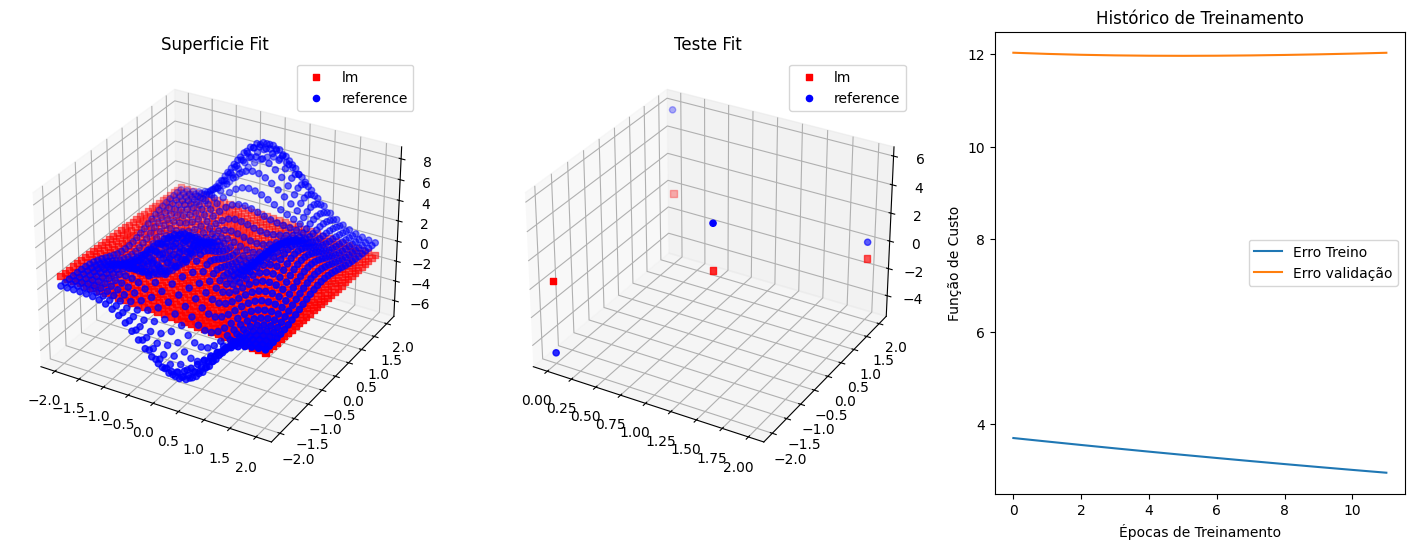

{'r2': -0.3514676791237814, 'r2_sup': -0.2678522815820188, 'r2_test': -0.24275654093040466, 'r2_val': -0.11585205702821688, 'r2_vt': -0.17227040043031838, 'mse': 5.6718206, 'mse_sup': 8.478134, 'mse_test': 19.03926, 'mse_val': 2.230917, 'mse_vt': 10.63509}
Elapsed time:  1.168840337000347
Stopped at epoch:  36
1/1 [==============================] - 0s 14ms/step


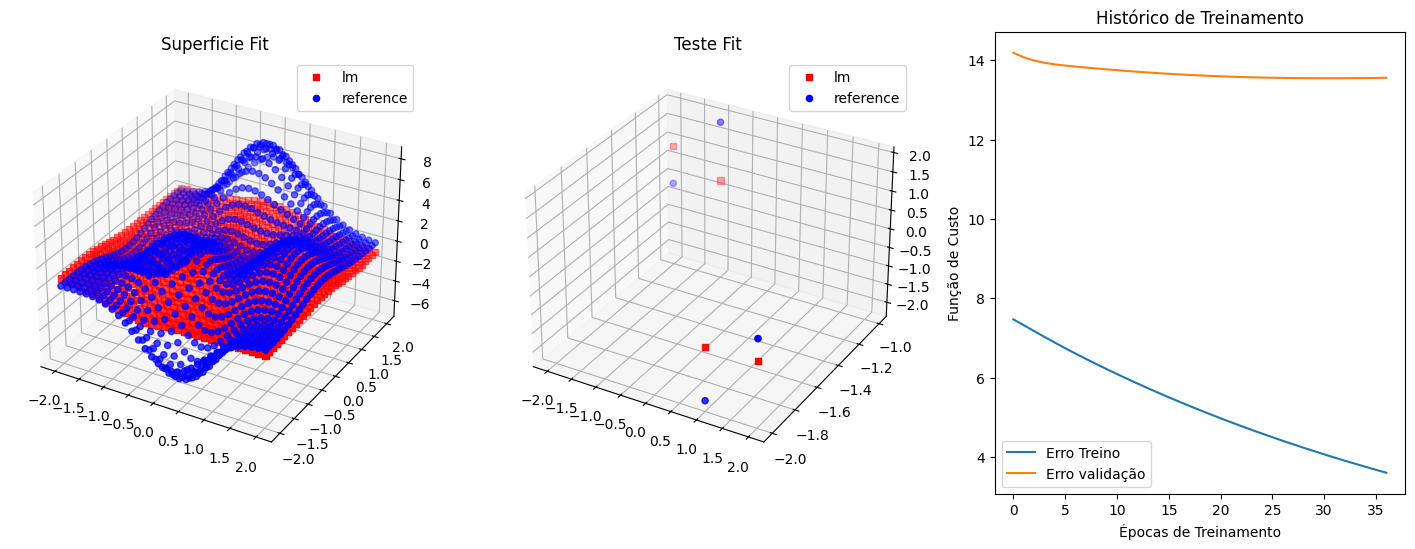

{'r2': 0.1992456793505274, 'r2_sup': 0.09422160613102093, 'r2_test': 0.2636797919387516, 'r2_val': -0.9196678984423559, 'r2_vt': 0.028099633002048208, 'mse': 3.3605945, 'mse_sup': 6.0569444, 'mse_test': 1.4426231, 'mse_val': 2.278202, 'mse_vt': 1.8604126}
Elapsed time:  4.001410526999734
Stopped at epoch:  129
1/1 [==============================] - 0s 14ms/step


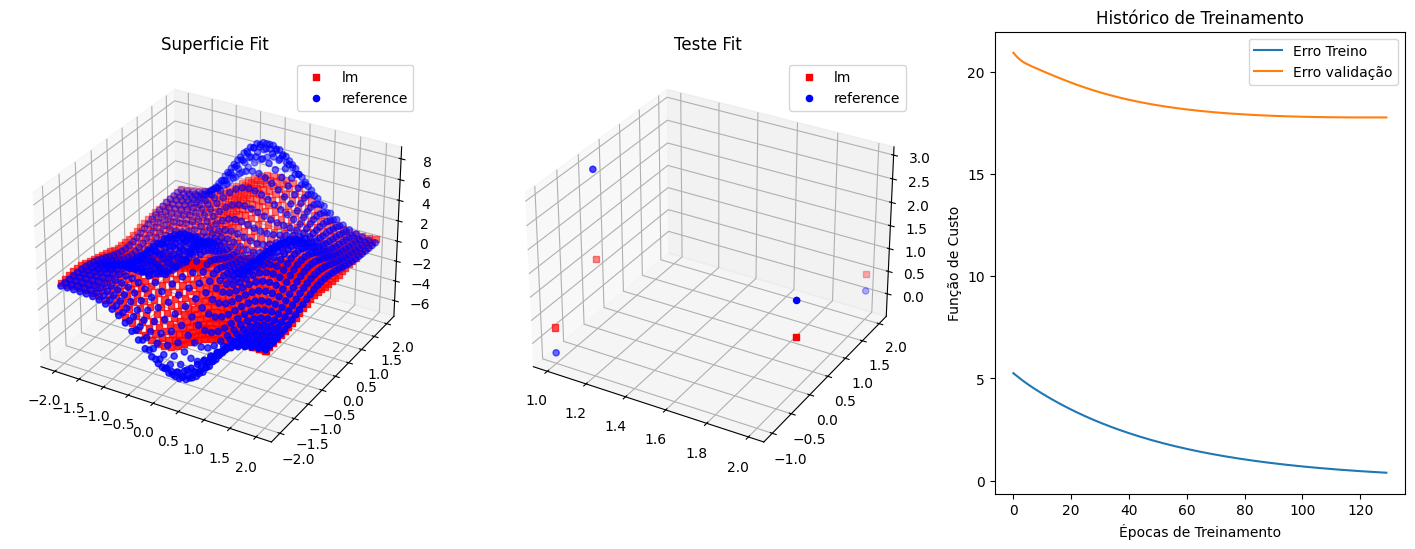

{'r2': 0.7536148803037341, 'r2_sup': 0.5215717157032121, 'r2_test': 0.25076388391772064, 'r2_val': 0.5373244837405219, 'r2_vt': 0.5816959930812989, 'mse': 1.0340257, 'mse_sup': 3.1992521, 'mse_test': 1.1768477, 'mse_val': 3.4275937, 'mse_vt': 2.3022208}
Elapsed time:  0.5323039649997554
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step


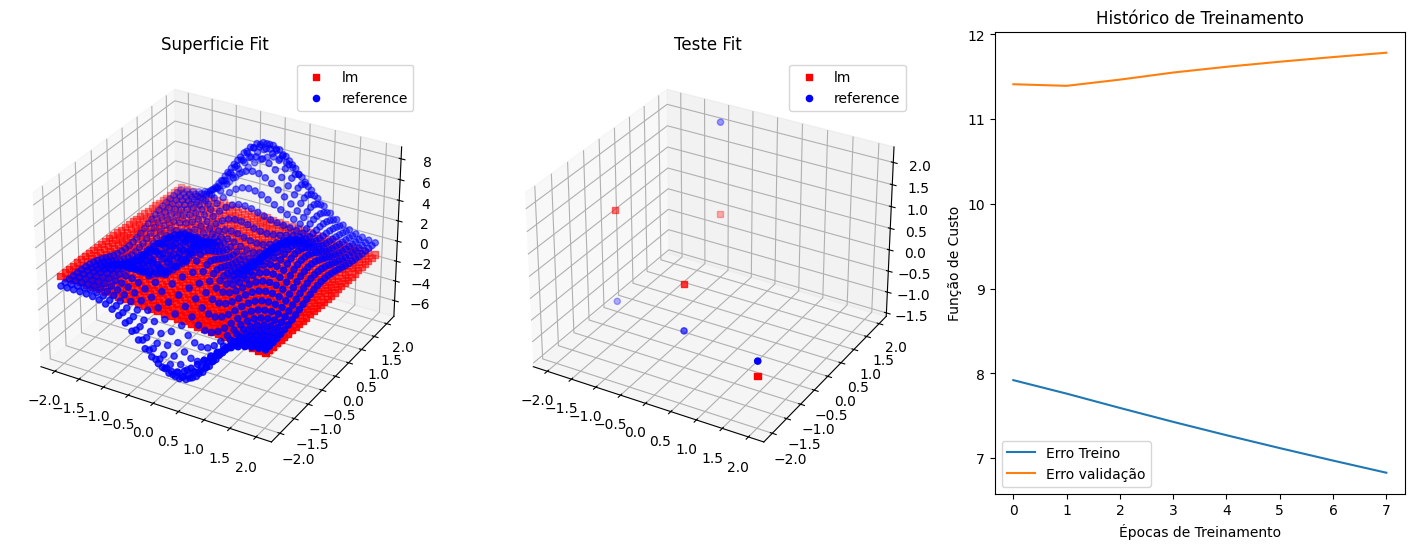

{'r2': -0.4229928614728795, 'r2_sup': -0.3208795365004269, 'r2_test': -0.5770081890461414, 'r2_val': -4.8101096444813605, 'r2_vt': -1.2055285203347248, 'mse': 5.971996, 'mse_sup': 8.832727, 'mse_test': 2.6414297, 'mse_val': 1.6969823, 'mse_vt': 2.1692061}
Elapsed time:  0.9245671690000563
Stopped at epoch:  10
1/1 [==============================] - 0s 15ms/step


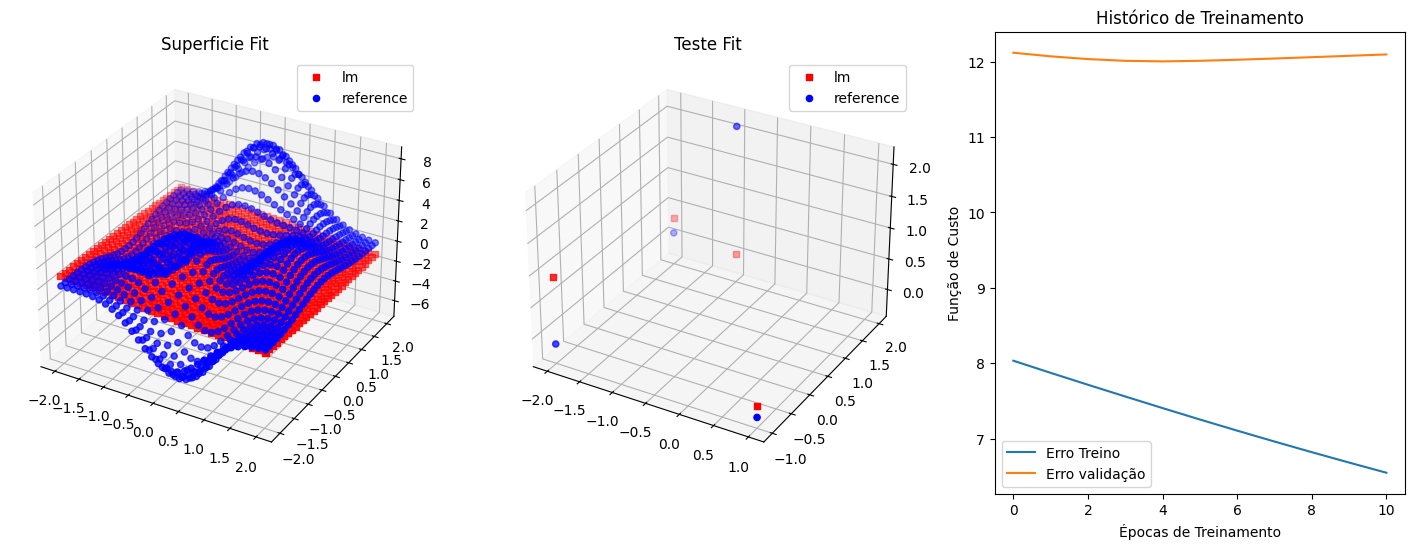

{'r2': -0.33846818303970294, 'r2_sup': -0.26391317509904866, 'r2_test': -0.4850562090117232, 'r2_val': -0.28640483277709117, 'r2_vt': -0.3102153230591169, 'mse': 5.617265, 'mse_sup': 8.451794, 'mse_test': 1.3764949, 'mse_val': 2.26235, 'mse_vt': 1.8194225}


In [15]:
metrics_df = []

for i in range(500):
  metrics_df.append(Test())

In [17]:
metrics_df.sort(key=lambda x: x['mse_sup'])
df = pd.DataFrame(metrics_df)
display(df)

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt
0,0.753615,0.521572,0.250764,0.537324,0.581696,1.034026,3.199252,1.176848,3.427594,2.302221
1,0.199246,0.094222,0.263680,-0.919668,0.028100,3.360595,6.056944,1.442623,2.278202,1.860413
2,-0.338468,-0.263913,-0.485056,-0.286405,-0.310215,5.617265,8.451794,1.376495,2.262350,1.819422
3,-0.351468,-0.267852,-0.242757,-0.115852,-0.172270,5.671821,8.478134,19.039261,2.230917,10.635090
4,-0.422993,-0.320880,-0.577008,-4.810110,-1.205529,5.971996,8.832727,2.641430,1.696982,2.169206
